### Testing some things in Scikit-learn, see what we can build

* This is learning/reinforcement/exploration I am doing inbetween section 4 and 5 of my PyTorch udemy course.
* Just some food for thought since I swap GPUs (I have about a dozen I rotate through)
  * For LLM on smaller (faster) models this 4070 Super UV'd is about as fast (within 3%) of my overclocked 7900 XTX

We will go from something like this:

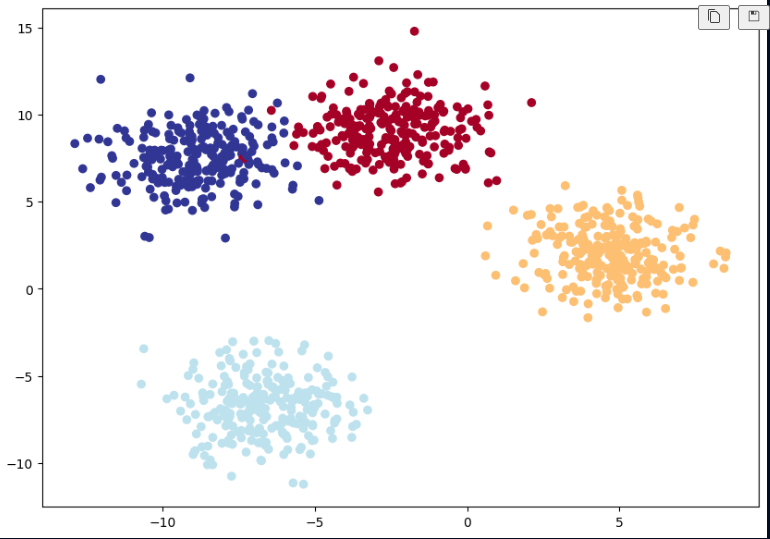

To a prediction like this:

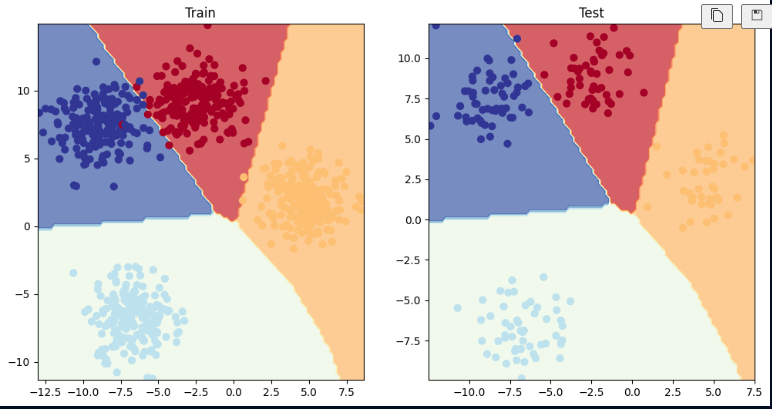

### We will mess around with this on the fly, see what works

* This code and its tensors will be running on an old Titan Xp via my remote Jupyter Lab box

jupyter lab --ip 10.0.0.31 --port 8888

jupyter lab --ip 127.0.01 --port 8888

In [1]:
import torch
torch.cuda.device_count()

1

In [3]:
!nvidia-smi

Sun Nov 10 09:35:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN Xp              WDDM  |   00000000:65:00.0  On |                  N/A |
| 30%   27C    P8             12W /  250W |     570MiB /  12288MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

X_blob_train shape: torch.Size([8000, 2])
y_blob_train shape: torch.Size([8000])
X_blob_test shape: torch.Size([2000, 2])
y_blob_test shape: torch.Size([2000])
Epoch: 0 | Train Loss: 2.50 | Train Acc: 10.19 | Test Loss: 2.39 | Test Acc: 13.20 | Device: cuda
Epoch: 3000 | Train Loss: 1.41 | Train Acc: 33.79 | Test Loss: 1.42 | Test Acc: 32.30 | Device: cuda
Epoch: 6000 | Train Loss: 2.48 | Train Acc: 8.55 | Test Loss: 2.49 | Test Acc: 7.45 | Device: cuda
Epoch: 9000 | Train Loss: 2.48 | Train Acc: 8.55 | Test Loss: 2.49 | Test Acc: 7.45 | Device: cuda


KeyboardInterrupt: 

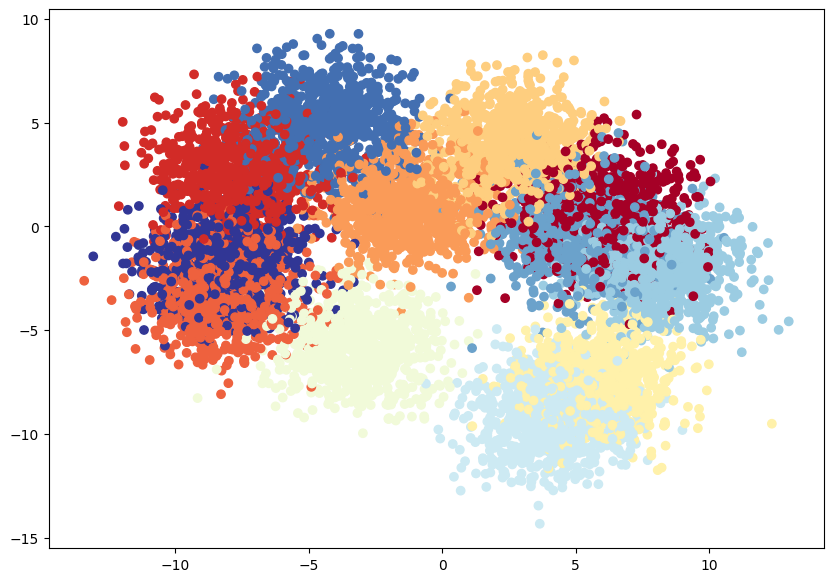

In [20]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
# We will need some scikit-learn things
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path
import numpy as np

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Random seed
RANDOM_SEED = 999

# Device selection, check for cuda, then xpu(intel arc), then cpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# We need to create scikit learn hyperparameters
# This is where we can set how many classes, features etc...
NUM_CLASSES = 12 # I dont think i've tested this high, we may have to adjust this
NUM_FEATURES = 2 # I dont think i've tested this high, we may have to adjust this

# Create scikit multiclass dataset, X_blob is the data, y_blob is the labels, thanks copilot
X_blob, y_blob = make_blobs(n_samples=10000, # started with 256 to see how this box handles it
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, # adds randomness to the data
                            random_state = RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float) # convert to a torch tensor
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # convert to a torch tensor

# Split data into train/test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state=RANDOM_SEED)

# Plot the data
plt.figure(figsize=(10, 7)) # set the size of the plot in inches
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu) # scatter plot of the data

# Build a multi-class model that can take args
class CoolModel1(nn.Module):
    def __init__(self, in_f, out_f, h_f): # We want to take in some args, make this nice and not understandable
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = in_f, out_features = h_f),
            nn.ReLU(),
            nn.Linear(in_features = h_f, out_features = h_f),
            nn.ReLU(),
            nn.Linear(in_features = h_f, out_features = h_f),
            nn.ReLU(),
            nn.Linear(in_features = h_f, out_features = out_f)
            )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model with args
model1 = CoolModel1(in_f = NUM_FEATURES, out_f = NUM_CLASSES, h_f = 4).to(device)

# Select loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # We are using cross entropy loss
optimizer = torch.optim.SGD(params = model1.parameters(), lr = 0.5) # We are using stochastic gradient descent

# Random seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set # of epochs
epochs = 30000

# Move data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Print shapes to debug
print(f"X_blob_train shape: {X_blob_train.shape}")
print(f"y_blob_train shape: {y_blob_train.shape}")
print(f"X_blob_test shape: {X_blob_test.shape}")
print(f"y_blob_test shape: {y_blob_test.shape}")

# Training and testing loop
for epoch in range(epochs):
    model1.train() # set model to training mode
    y_logits = model1(X_blob_train) # set the logits to our test data
    y_pred = torch.softmax(y_logits, dim = 1) # set the predictions to our test data
    loss = loss_fn(y_logits, y_blob_train) # set the loss to our test data
    acc = accuracy_fn(y_true=y_blob_train, y_pred=torch.argmax(y_logits, dim=1))
    optimizer.zero_grad() # zero the gradients
    loss.backward() # backpropagation
    optimizer.step() # update the weights
    # Testing
    model1.eval() # set model to evaluation mode
    with torch.inference_mode():
        test_logits = model1(X_blob_test)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=torch.argmax(test_logits, dim=1))
    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.2f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f} | Device: {device}")

# Download helper function and import
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Modified plot_decision_boundary function
def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Make predictions
    X_to_pred_on = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float)
    
    # Ensure the input data has the correct number of features
    if X_to_pred_on.shape[1] != model.linear_layer_stack[0].in_features:
        X_to_pred_on = torch.cat([X_to_pred_on, torch.zeros((X_to_pred_on.shape[0], model.linear_layer_stack[0].in_features - 2))], dim=1)

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape predictions and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Use the modified plot_decision_boundary function
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_blob_test, y_blob_test)
plt.show()